# Step5 演習01 アンダーフィッティングとオーバーフィッティング
---

Step5ではアンダーフィッティングとオーバーフィッティングの見分け方と対策法を学習します。今回は線形回帰の例を用います。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- アンダーフィッティングとオーバーフィッティングの見分け方や対策方法を学ぶ。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [SciPy](https://docs.scipy.org/doc/) 数値解析ライブラリの基本パッケージの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from functools import partial #関数の一部の引数を固定するのに使う
import os
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## サンプルデータのロードとインデックスの生成

サンプルデータをロードします。線形関数ではフィッティングできないものの、さほど複雑ではない分布をしているデータが格納されています。

In [5]:
data = np.loadtxt("./dataStep5/dataStep5.csv", delimiter=",")
data_m, data_n = data.shape

各訓練例をシャッフルしてインデックスをつけておきます。扱う訓練例が少ないため、人為的に選んだインデックスを使います。

In [6]:
if os.path.isfile("./dataStep5/dataStep5_shuffle_idx.csv") == True:
    shuffle_idx = np.loadtxt("./dataStep5/dataStep5_shuffle_idx.csv", delimiter = ",", dtype=np.uint8)

else:
    shuffle_idx =  np.random.permutation(data_m)
    np.savetxt("./dataStep5/dataStep5_shuffle_idx.csv", shuffle_idx, delimiter=",", fmt = "%d")

上のセルを実行したことによりデータセットを "data" に格納しました。下のセルを実行して、dataのshapeを確認しましょう。

In [7]:
data.shape

(200, 2)

(200,2)と表示されたはずです。今回使うデータセットは200行2列の行列がdataに格納されています。

## データのセット

** 訓練集合(X, y) **,**  交差検証集合(Xval, yval) **, ** テスト集合(Xtest, ytest) **としてそれぞれ6:2:2程度の分量に`data`を分割しておきます。視覚的に状況を分かりやすくするため、訓練例は30個程度に絞ります。

今回はインデックスを再現できるように手動で分割しますが、実践の場面でランダム化したうえ分割する場合、`sklearn.model_selection.train_test_split()`関数を使うと便利でしょう。

参考：[scikit-learnチュートリアル sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [8]:
#訓練集合
X = data[shuffle_idx[:30],0]
y = data[shuffle_idx[:30],1]
#交差検証集合
Xcv = data[shuffle_idx[30:40],0]
ycv = data[shuffle_idx[30:40],1]
#テスト集合
Xtest = data[shuffle_idx[40:50],0]
ytest = data[shuffle_idx[40:50],1]

In [9]:
print("訓練集合 Xの個数:", X.shape[0])
print("交差検証集合 Xcvの個数:", Xcv.shape[0])
print("テスト集合 Xtestの個数:", Xtest.shape[0])

訓練集合 Xの個数: 30
交差検証集合 Xcvの個数: 10
テスト集合 Xtestの個数: 10


In [10]:
m = X.shape[0] #訓練例の数はm
m_cv = Xcv.shape[0] #交差検証例の数はm_val

In [11]:
print("訓練例の数:", m)
print("交差検証例の数:",  m_cv)

訓練例の数: 30
交差検証例の数: 10


## データのプロット

**【課題１】** 訓練例と交差検証例をプロットする関数`plotData(X, y, Xcv, ycv)`を書きましょう。訓練例と交差検証例は区別するために色を指定しましょう。

参考：[matplotlob 公式チュートリアル matplotlib.pyplot.scatter](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)

- matplotlib.pyplot.scatterで散布図を表示します。

In [12]:
#Coursemale-02 Step5 QuestionNumber1 80169b532acc39bd775f6da53633c5ed
def plotData(X, y, Xcv, ycv):
###############ここを穴埋めしてください###############
    plt.scatter(X, y, c="b", label=u'訓練データ')
    plt.scatter(Xcv, ycv, c="r", label=u'交差検証データ')
    plt.xlim([-5,5])
    plt.ylim([-1,5])
    plt.legend(loc="upper left")
    plt.draw()    
 
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [13]:
%%bash
./validation_client.py male-02 5 1 Step5_01.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



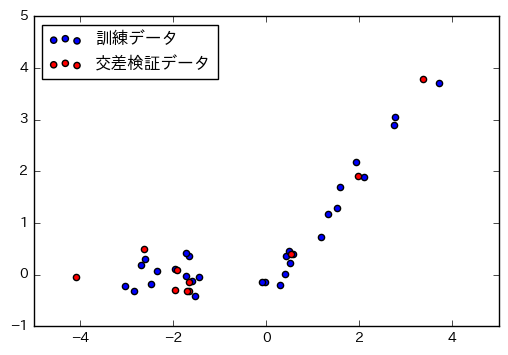

In [14]:
plotData(X, y, Xcv, ycv)

## 正則化線形回帰の目的関数

正則化された線形回帰の目的関数を実装します。その前に、パラメータ$\theta$を初期化し、正則化パラメータラムダは１にします。

In [15]:
theta = np.ones(2) # thetaは1-dim
lmd = 1

**【課題２】** 正則化された線形回帰の目的関数`linearRegCostFunction(theta, X, y, lmd)`を実装しましょう。`XwithBias`は`X`にバイアスを付加したものとします。

$$J(\theta_0, \theta_1) = \frac{1}{2m}\sum^{m}_{i=1}(h_{\boldsymbol{\theta}}(x^{(i)})-y^{(i)})^2  + \frac{\lambda}{2m}\sum^{n}_{j=1}\theta_j^2$$

** Note： **<br>
- $\theta_0$はバイアス項のため正則化を行いません。

In [55]:
#Coursemale-02 Step5 QuestionNumber2 0b69f3cd01c23b78867e8f34b3b9d5a2
def linearRegCostFunction(theta, XwithBias, y, lmd):
###############ここを穴埋めしてください###############
    m = y.size
    J = ((np.dot(XwithBias, theta.T) - y)**2).sum() / (2*m) + (lmd / (2*m)) * (theta[1:]**2).sum()
    return J
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [56]:
%%bash
./validation_client.py male-02 5 2 Step5_01.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



念のためちゃんと走るか確認してみましょう。（正しい答えかどうかは分からない）

In [57]:
J = linearRegCostFunction(theta, np.c_[np.ones([m,1]),X], y, lmd) # Xはバイアスをつけた状態で渡す

In [58]:
print("thetaが[1, 1]のときのコストJは", J)

thetaが[1, 1]のときのコストJは 0.7270372836123554


## 正則化線形回帰の目的関数の勾配(gradient)

**【課題３】** 正則化された線形回帰の目的関数の勾配`linearRegGrad(theta, XwithBias, y, lmd)`を実装しましょう。`XwithBias`は`X`にバイアスを付加したものとします。

$$\frac{\partial}{\partial \theta_j}J(\boldsymbol{\theta})=\frac{1}{m}\sum_{i=1}^{m}(h_{\boldsymbol{\theta}}(x^{(i)})-y^{(i)})x^{(i)} +  \frac{\lambda}{m}\sum^{n}_{j=1}\theta_j$$

パラメータ$\theta_{0},\theta_{1}$に関数する勾配は次のようになります。

$$\frac{\partial}{\partial \theta_0}J(\boldsymbol{\theta_0})=\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{0}^{(i)}$$
$$\frac{\partial}{\partial \theta_1}J(\boldsymbol{\theta_1})=\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{1}^{(i)}+\frac{\lambda}{m}{\theta_1}$$

In [59]:
#Coursemale-02 Step5 QuestionNumber3 dbee1c36b59a507128480539e13a164d
def linearRegGrad(theta, XwithBias, y, lmd):
###############ここを穴埋めしてください###############
    m = y.size
    grad = XwithBias.T.dot(np.dot(XwithBias, theta) - y) / m + (lmd / m) * np.r_[0, theta[1:]]
    return grad
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [60]:
%%bash
./validation_client.py male-02 5 3 Step5_01.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes
Error regarding to send score



念のためちゃんと走るか確認してみましょう。（正しい答えかどうかは分からない）

In [61]:
grad = linearRegGrad(theta, np.c_[np.ones([m,1]),X], y, lmd) # Xはバイアスつけた状態で渡す

In [62]:
print("thetaが[1, 1]のときの目的関数のgradは", grad)

thetaが[1, 1]のときの目的関数のgradは [0.13541991 1.92030114]


## 線形回帰の学習

**【課題４】** 線形回帰モデルをつかって学習する関数`trainLinearReg(X, y, lmd)`を実装しましょう。`XwithBias`は`X`にバイアスを付加したものとします。返値はパラメータの配列`theta`になるようにしてください。

**【Note】**
- わからない部分はヒントを参考にしてください。
- **最適化**はSciPyのアルゴリズムで実装します。詳細は「Step3演習02 勾配法による最適化」で詳しく紹介しています。

In [63]:
#Coursemale-02 Step5 QuestionNumber4 e004d9191eca1eddf8ce00f496038bc6
def trainLinearReg(XwithBias, y, lmd):
###############ここを穴埋めしてください###############
    m, n = XwithBias.shape # Xはここではバイアス項を付け加えているので2-dim

    # thetaの初期化
    #initial_thetaは1-dim
    initial_theta = np.zeros(n)

    # 最適化する変数以外は固定 
    cost_fixed = partial(linearRegCostFunction, XwithBias=XwithBias, y=y, lmd=lmd) #functools
    grad_fixed = partial(linearRegGrad, XwithBias=XwithBias, y=y, lmd=lmd) #functools

    # 最適化
    res = scopt.minimize(cost_fixed, initial_theta, method='BFGS', jac=grad_fixed)

    return res.x
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [64]:
%%bash
./validation_client.py male-02 5 4 Step5_01.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



線形回帰を正則化なし(lmd=0)で学習させます。

In [65]:
lmd = 0

In [66]:
theta = trainLinearReg(np.c_[np.ones([m,1]),X], y, lmd)

学習済みのパラメータを用いてグラフをプロットします。

In [67]:
def plotDataWithLine(X, y, Xcv, ycv, theta):
    #課題１で実装してもらった関数です
    plotData(X, y, Xcv, ycv)
    
    #このセル内で直前にプロットしたものに上書きしていきます
    plt.hold(True)
    
    #得られたthetaをもとにグラフの画面の端と端をプロットしてその間に直線で引くことで、回帰直線を掃引します。
    plt.plot([-5, 5], [(-5)*theta[1]+theta[0], 5*theta[1]+theta[0]], label=u'線形回帰') 
    
    #念のため、グラフの端をもう一度指定しておきます。
    plt.xlim([-5,5])
    plt.ylim([-1,5])
    
    #凡例を入れます。
    plt.legend(loc="upper left")
    
    plt.show()

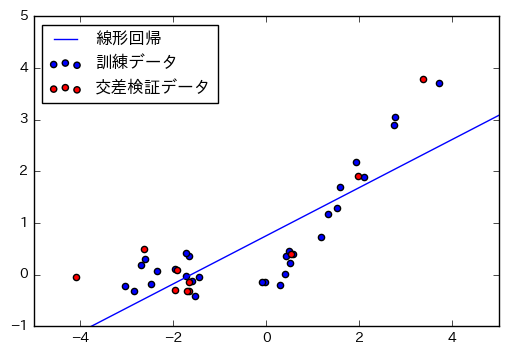

In [68]:
plotDataWithLine(X, y, Xcv, ycv, theta)

現時点でもアンダーフィッティングしている（高バイアスである）ことがわかります。

正則化パラメータを極端に大きくすると（例えば lmd = 100000）、さらにアンダーフィッティング傾向が強まることを各自確認しましょう。

## 学習曲線

横軸に学習させた訓練例の個数、縦軸に学習誤差と交差検証誤差をプロットしたものを学習曲線というのでした。これを使ってアンダーフィッティングやオーバーフィッティングを見分けましょう。

**【課題５】** 学習曲線をプロットするための、学習誤差と交差検証誤差を出力する関数`learningCurve(XwithBias, y, XcvWithBias, ycv, lmd)`を書きましょう。なお、返値である学習誤差と交差検証誤差は、それぞれ訓練例の個数分の要素を持った1次元配列とします。以下を穴埋めしていきましょう。

In [69]:
#Coursemale-02 Step5 QuestionNumber5 39efc12857ad9120a60291e7ffeb4b80
def learningCurve(XwithBias, y, XcvWithBias, ycv, lmd):
    m, n = XwithBias.shape # ここのXは2-dim
    m_cv, n_cv = XcvWithBias.shape

    error_train = np.empty(m)
    error_cv = np.empty(m)

###############ここを穴埋めしてください###############
    for i in range(m):
        theta = trainLinearReg(XwithBias[:i+1], y[:i+1], lmd)
        error_train[i] = ((XwithBias[:i+1].dot(theta)-y[:i+1])**2).sum() / (2*(i+1))
        error_cv[i] = ((XcvWithBias.dot(theta)-ycv)**2).sum() / (2*m_cv)
######################################################
        
    return [error_train, error_cv]

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [70]:
%%bash
./validation_client.py male-02 5 5 Step5_01.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



---
**【課題５別解】（参考）**

この課題については参考として、内包表記を用いた解答例を載せておきます。

In [71]:
def learningCurve(XwithBias, y, XcvWithBias, ycv, lmd):
    theta = np.array([trainLinearReg(XwithBias[:i+1], y[:i+1], lmd) for i in range(XwithBias.shape[0])])
    return np.array([[((XwithBias[:i+1].dot(theta[i])-y[:i+1])**2).sum() / (2*(i+1)), \
                     ((XcvWithBias.dot(theta[i])-ycv)**2).sum() / (2*XcvWithBias.shape[0])] for i in range(XwithBias.shape[0])]).T

---

In [72]:
# XとXvalはバイアスつけた状態で渡す
error_train, error_cv = learningCurve(np.c_[np.ones([m,1]),X], y, np.c_[np.ones([m_cv,1]), Xcv], ycv, lmd)

In [73]:
def plotLearningCurve(error_train, error_cv):
    plt.plot(range(1,m+1), error_train, label=u"訓練集合")
    plt.plot(range(1,m+1), error_cv, label=u"交差検証集合")
    plt.legend(loc="best")
    plt.title(u"線形回帰の学習曲線")
    plt.xlabel(u"訓練例の数")
    plt.ylabel(u"誤差")
    plt.ylim([0, 0.4])
    plt.draw()

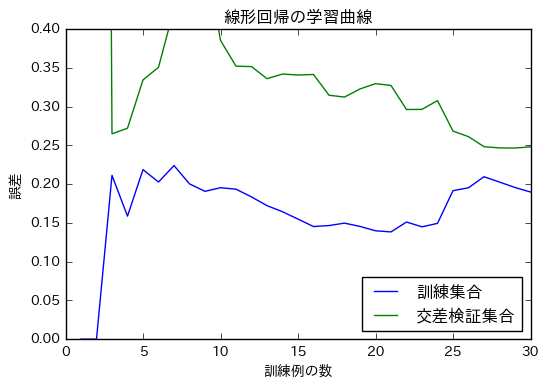

In [74]:
plotLearningCurve(error_train, error_cv)

訓練集合と交差検証集合の開きは徐々になくなっていますが、誤差はかなり高めです。

アンダーフィッティングしている可能性があることをこのグラフから感じ取って下さい。

念のため結果の数字を一覧すると、

In [75]:
print("訓練例\t学習誤差\t交差検証誤差")
for i in range(m):
    print(i+1, end="")
    print("\t", end="")
    print("%0.8f"%error_train[i], end="")
    print("\t", end="")
    print("%0.8f"%error_cv[i])

訓練例	学習誤差	交差検証誤差
1	0.00000000	1.27878282
2	0.00000000	3.51212524
3	0.21138225	0.26493007
4	0.15870733	0.27216964
5	0.21875317	0.33452374
6	0.20274885	0.35078881
7	0.22400597	0.42598839
8	0.20034254	0.44700349
9	0.19072057	0.49841247
10	0.19541497	0.38554669
11	0.19350597	0.35223032
12	0.18352603	0.35170627
13	0.17229018	0.33608805
14	0.16444138	0.34207928
15	0.15490137	0.34080917
16	0.14531298	0.34153584
17	0.14657393	0.31475212
18	0.14970840	0.31235615
19	0.14545523	0.32284300
20	0.13983305	0.32967568
21	0.13837905	0.32733903
22	0.15112796	0.29630724
23	0.14494354	0.29651753
24	0.14939919	0.30780913
25	0.19159555	0.26846663
26	0.19533595	0.26131076
27	0.20957286	0.24833908
28	0.20270188	0.24677189
29	0.19571833	0.24659199
30	0.18986441	0.24818306
